## **Car Model Identifier Using ResNet50 with Progressive Unfreezing**

This exercise tackles the *Stanford Cars Dataset* using **ResNet50** for fine-grained image classification. The task involves **classifying car images into 196 distinct models**. 

To improve transfer learning performance, we adopt a **progressive unfreezing strategy** when tuning. Rather than unfreezing the entire network at once, we gradually fine-tune layers in three stages:

&nbsp;&nbsp;&nbsp;&nbsp;☢️ *Stage 1:* Train only the classifier head and deep layers.  
&nbsp;&nbsp;&nbsp;&nbsp;☢️ *Stage 2:* Unfreeze mid-level layers.  
&nbsp;&nbsp;&nbsp;&nbsp;☢️ *Stage 3:* Unfreeze the early layers of the backbone.  

This approach allows the model to adapt higher-level features first while preserving the stability of low-level ones, reducing the risk of catastrophic forgetting.  

### **Task Objectives**

&nbsp;&nbsp;&nbsp;&nbsp;⚡ Create an ideal training/validation split from the original training set    
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Keep the official test set untouched until the final model evaluation     
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Visualize the dataset for insights on car model distribution and image content  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Explore target labels so we can identify class imbalances or other patterns     
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Perform a multi-stage training procedure with progressive unfreezing of layers  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Apply data augmentation to improve generalization and reduce overfitting  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Evaluate model performance using top-1 accuracy, precision, recall, and f1

### **Task Workflow**

The workflow is organized into:

&nbsp;&nbsp;&nbsp;&nbsp;✅ *Exploratory Data Analysis (EDA)*  
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Data Preprocessing*  
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Model Tuning*  

### **Dataset Information**

&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Class Count:* 196  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Official Train Size:* 8144  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Official Test Size:* 8041  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Image Resolution:* Varies, many high-res  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Task:* Fine-grained classification of car models    
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Source:* [Dataset Page on Kaggle](https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder)  

### **Model Information**

&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Model:* ResNet50  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Parameters:* ~25.6M  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Top-1 Accuracy (ImageNet):* ~76%  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Recommended Input Resolution:* 224x224  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Architecture:* CNN with Residual blocks  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Source:* [Paper](https://arxiv.org/pdf/1512.03385)  

In [1]:
# Standard library
from collections import Counter
import os
from pathlib import Path
import time

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from plotly import express as px
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split as tts

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Ensure reproducibility with seeds
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **1. EDA**

&nbsp;1.1 Set Up Device, Dataset Paths, and Labels  
&nbsp;1.2 Visualize the Dataset  
&nbsp;1.3 Check for Class Imbalance  

### **1.1 Set Up Device, Dataset Paths, and Labels**

- Check if a GPU is available, if not default to CPU.
- Collect image paths and labels from the `train` and `test` subdirectories.
- Split 10% of training data for validation upfront, so we can analyze stats on the training set alone.
- *Note:* We keep Stanford Cars official test set completely isolated until the final evaluation.

In [2]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device In Use: {str(device).upper()}")

# Helper function for retrieving image paths and labels
def get_img_paths_and_labels(base_dir):
    image_paths = np.array(list(Path(base_dir).glob("*/*.jpg")))
    labels = [p.parent.name for p in image_paths]
    return image_paths, labels
    
# Paths to train and test subdirectories
train_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
test_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'

# Collect training and test paths and labels
orig_train_paths, orig_train_labels = get_img_paths_and_labels(train_dir)
test_paths, test_labels = get_img_paths_and_labels(test_dir)

# Split 10% of training data for validation
split = tts(orig_train_paths, 
            orig_train_labels, 
            test_size=0.1, 
            shuffle=True, 
            stratify=orig_train_labels)

train_paths, val_paths, train_labels, val_labels = split

# Compute and print subset sizes
print(f"Train Set Size: {len(train_paths)}")
print(f"Validation Set Size: {len(val_paths)}")
print(f"Test Set Size: {len(test_paths)}")

Device In Use: CUDA
Train Set Size: 7329
Validation Set Size: 815
Test Set Size: 8041


### **1.2 Visualize the Dataset**

In [3]:
# See typical image sizes
sizes = []
for img_path in train_paths:
    with Image.open(img_path) as img:
        channels = len(img.getbands())
        sizes.append(img.size + (channels,))  

print("((width, height, channels), count)")
Counter(sizes).most_common(7)

((width, height, channels), count)


[((640, 480, 3), 879),
 ((1024, 768, 3), 422),
 ((259, 194, 3), 355),
 ((480, 360, 3), 176),
 ((300, 225, 3), 174),
 ((800, 600, 3), 127),
 ((1600, 1200, 3), 121)]

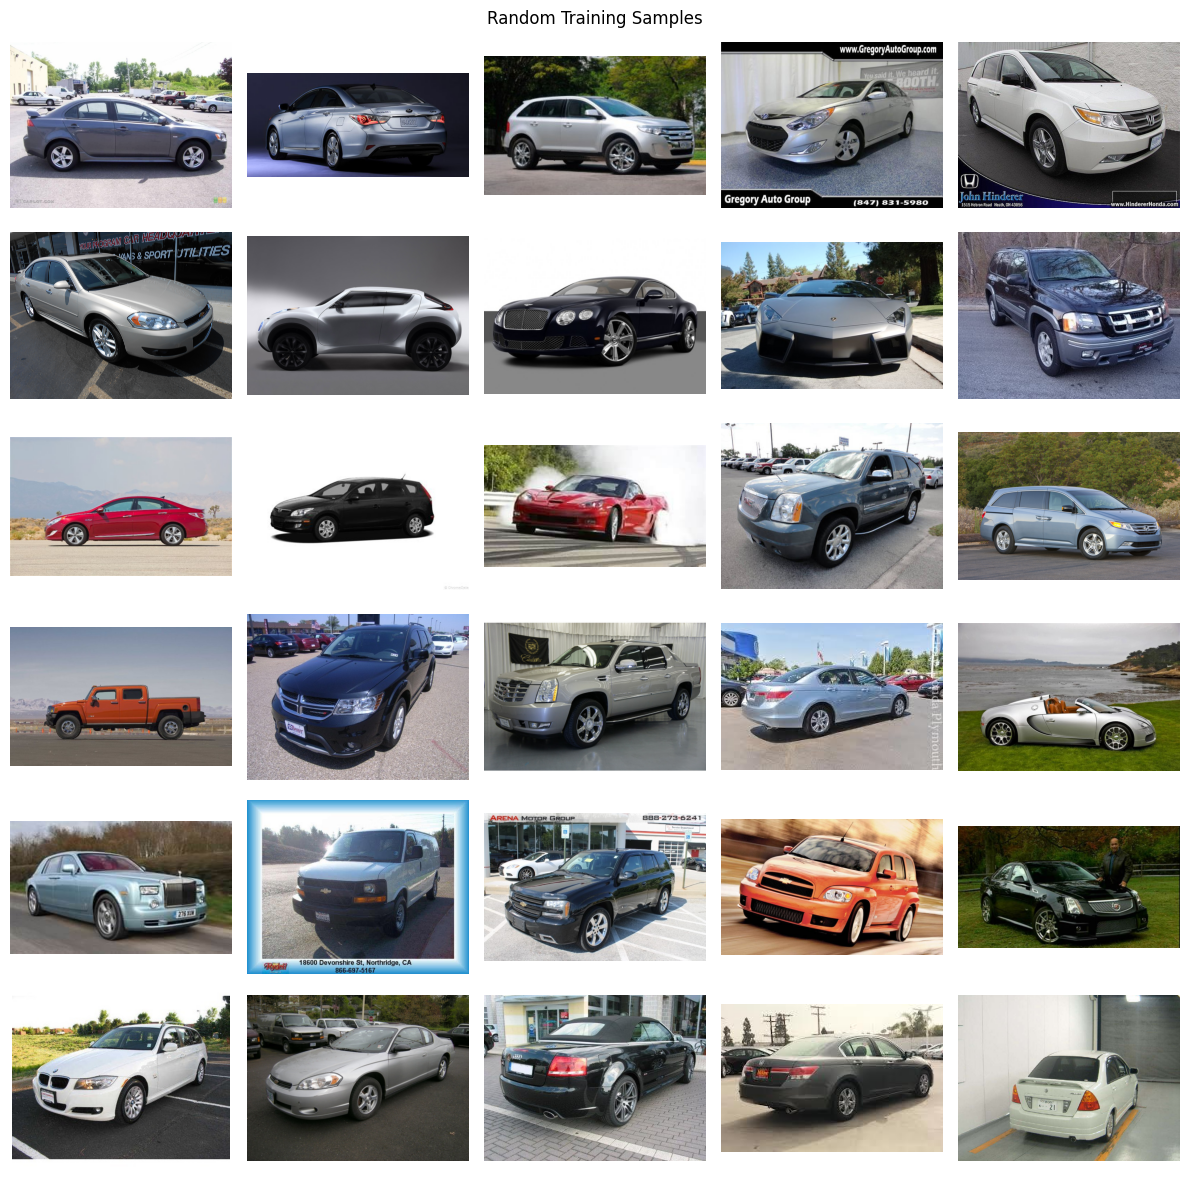

In [4]:
def show_random_images(paths, title, n_row=3, n_col=3, transform=None):
    """Reusable function for displaying random images."""
    
    fig1, axs1 = plt.subplots(n_row, n_col, figsize=(12, 12))
    rand_imgs = np.random.choice(paths, n_row*n_col, replace=False)
    for idx, ax in enumerate(axs1.flat):
        img = Image.open(rand_imgs[idx]).convert("RGB")
        if transform: 
            img = transform(img)
            img = img.permute(1, 2, 0).numpy()        
        ax.imshow(img)
        ax.axis("off")
    fig1.suptitle(title)
    plt.tight_layout()
    plt.show()

# See random training images
show_random_images(train_paths, "Random Training Samples", 6, 5)

### **1.3 Check for Class Imbalance**

Class imbalance can cause the model to **favor majority classes**. 

To see if there are class imbalances in the dataset, we can perform the following analyses:

- Visualize the class distribution using an interactive bar chart 
- Compute statistical metrics (e.g., Imbalance Ratio) to quantify the extent of imbalance



#### **1.3.1 Visualize Class Distribution**

In [5]:
# Helper function for counting class frequency
def label_counter(labels):
    label_counter = Counter(labels)
    key = lambda x:x[1]
    sorted_count = sorted(label_counter.items(), key=key, reverse=True)
    sorted_count_dict = dict(sorted_count)
    return sorted_count_dict

# Count class freq
train_label_counts = label_counter(train_labels)
val_label_counts = label_counter(val_labels)

# Create interactive bar chart
fig2 = px.bar(x=train_label_counts.keys(),
             y=train_label_counts.values(),
             title="Class Distribution (Train Set)",
             labels={"x":"Car Model Bin", "y":"Number of Images"})
fig2.update_layout(xaxis=dict(showticklabels=False), height=600,)
fig2.show(renderer="iframe")

**Takeways:**

- The drop from the highest bar (slightly above 50) to the next (just below 40) is sharp, but afterward, the decline is gradual.
- The range of counts is relatively tight with one outlier on the left, so imbalance likely won’t dominate training.

#### **1.3.2 Compute Statistical Metrics**

In [6]:
# Helper func for computing Imbalance Ratio
def comp_imb_ratio(labels):
    label_counts = label_counter(labels)
    counts_arr = np.array(list(label_counts.values()))
    max_label, min_label = counts_arr.max(), counts_arr.min()
    imb_ratio = max_label / min_label
    return imb_ratio

# Helper func for computing Gini Coefficient
def comp_gini_coef(labels):
    label_counts = label_counter(labels)
    counts_arr = np.array(list(label_counts.values()))
    numerator = np.abs(np.subtract.outer(counts_arr, counts_arr)).sum()
    denominator = (2*len(counts_arr) * counts_arr.sum())
    gini_coef = numerator / denominator
    return gini_coef

# Compute train label IR and GC 
train_imb_ratio = comp_imb_ratio(train_labels)
train_gini_coef = comp_gini_coef(train_labels)
print(f"Train Subset IR: {train_imb_ratio:.2f}")
print(f"Train Subset GC: {train_gini_coef:.4f}", "\n")

Train Subset IR: 2.77
Train Subset GC: 0.0515 



**Takeaways:**

- No severe skew in the train set. The largest class has approx. 2.84x more samples than the smallest, indicating a light imbalance.
- GC for the train set labels is approx. 0.05 which is close to 0. This tells us the class distribution is fairly even.

## **2. Preprocessing**

&nbsp;2.1 Set Up a `transforms` Pipeline  
&nbsp;2.2 Instantiate `Dataset` Objects  
&nbsp;2.3 Wrap `Dataset`s in `DataLoader`  

### **2.1 Set Up a `transforms` Pipeline**

We create a `transforms` pipeline to preprocess and augment the dataset. This helps improve model generalization by **introducing variability** during training. 

The *training pipeline* includes:

- `RandomResizedCrop`: Randomly crops and resizes the image.
- `RandomHorizontalFlip`: Flips the image horizontally with 50% probability.
- `RandomRotation`: Rotates the image randomly.
- `ColorJitter`: Randomly adjusts brightness and contrast.
- `RandAugment`: Additional random augmentations for stronger variability
- `Normalize`: Normalizes tensor using ImageNet stats.

For the *validation pipeline*, only essential transformations are applied (`Resize`, `CenterCrop`, and `Normalize`). 

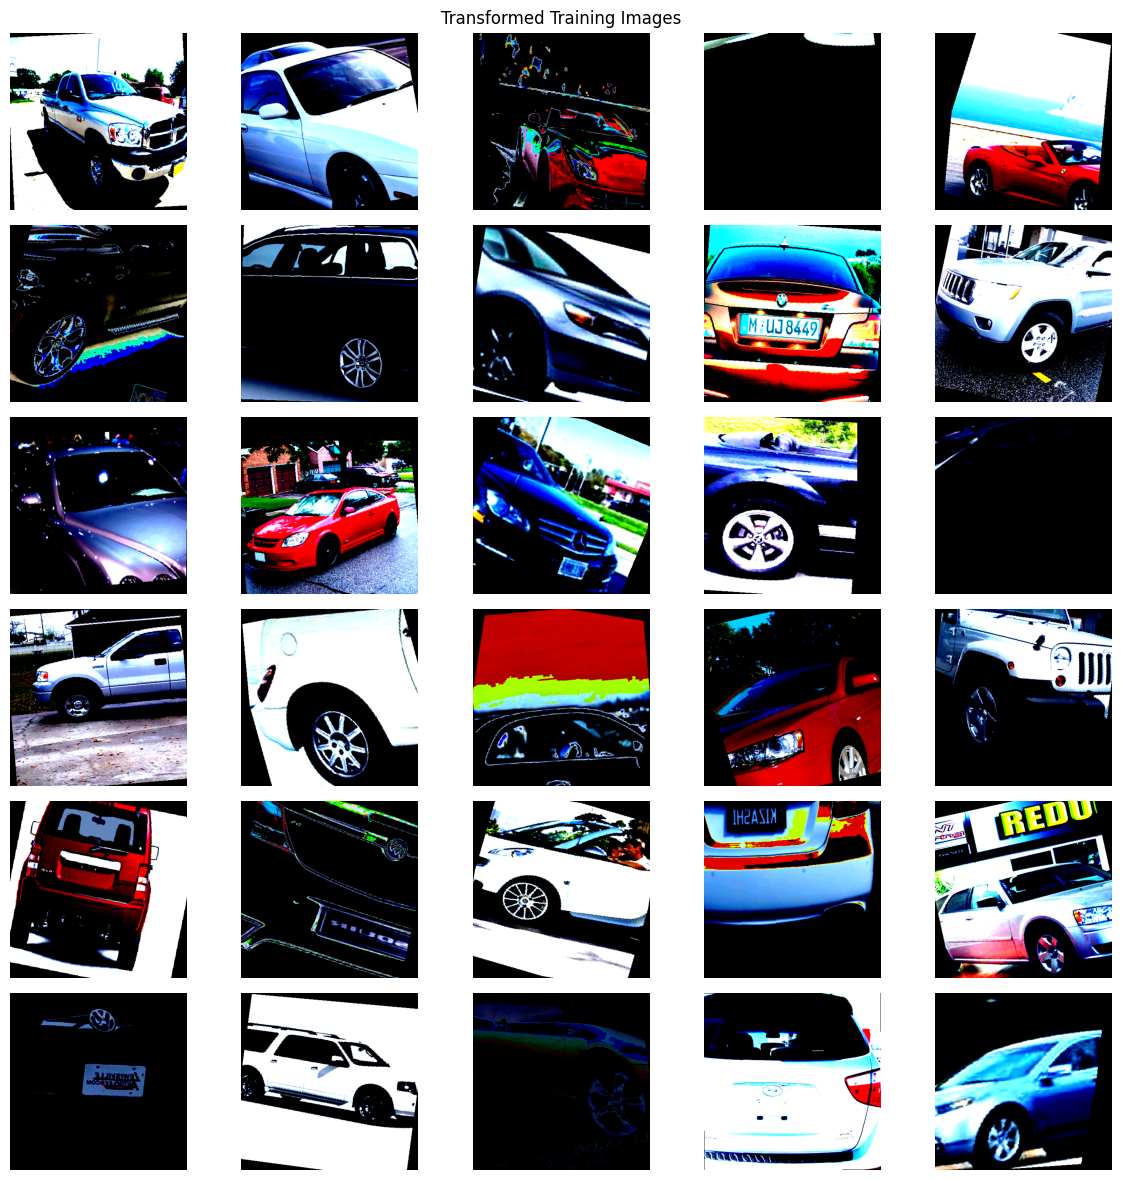

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# See some transformed images
show_random_images(train_paths, "Transformed Training Images", 6, 5, transform=train_transforms)

### **2.2 Instantiate `Dataset` Objects**

We define a custom `Dataset` class for creating datasets of image paths and labels:

- Stores image file paths and string labels
- Maps string labels to int indices
- Reverse-map indices to string labels
- Applies a `transforms` pipeline
- Supports standard `len()` and item indexing

***Note:*** We could have also relied on `ImageFolder` prior to splitting the original training paths for validation.

In [8]:
class CarImageDataset(Dataset):
    def __init__(self, paths, str_labels, transform=None, classes=None):
        self.paths = paths
        self.str_labels = str_labels
        self.transform = transform
        
        if not classes: 
            classes = sorted(list(set(str_labels)))
            
        self.classes = classes
        self.cl_to_idx = {c:i for i,c in enumerate(classes)}
        self.idx_to_cl = {i:c for c,i in self.cl_to_idx.items()}
        self.labels = [self.cl_to_idx[l] for l in self.str_labels]        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        str_label = self.str_labels[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, str_label

# Instantiate Dataset objects
train_data = CarImageDataset(train_paths, train_labels, transform=train_transforms)
val_data = CarImageDataset(val_paths, val_labels, transform=val_transforms)

### **2.3 Wrap `Dataset`s in `DataLoader`**

- Shuffle data when batching
- Use a batch size of 32 samples
- Use 2 workers for parallel data loading
- Set `pin_memory=True`

In [9]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,     
    shuffle=True,      
    num_workers=2,
    pin_memory=True)

val_loader = DataLoader(
    val_data, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True)

## **3. Model Setup and Tuning**

&nbsp;3.1 Define Functions for Model Evaluation and Training  
&nbsp;3.2 Model Tuning Strategy: Progressive Unfreezing  
&nbsp;3.3 Evaluate on the Test Set

### **3.1 Define Functions for Model Evaluation and Training**

- `eval_model` runs a single forward pass  to evaluate model performance.
- `train_epoch` executes one training epoch, updating parameters per batch.
- `train_model` uses both helper functions to orchestrate full tuning across epochs.
- `plot_loss_acc` plots the training run's loss and accuracy history

In [10]:
# For model evaluation or inference
def evaluate_model(model, loader, criterion, add_metrics=False):
    model.eval()
    running_loss = 0
    num_correct = 0
    total = 0
    all_labels, all_preds = [], []
    start = time.time()
    
    with torch.no_grad():  
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            num_correct += (predicted == labels).sum().item()
            total += labels.size(0)     
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    eval_metrics = running_loss/total, num_correct/total
    
    if add_metrics:
        prc = precision_score(all_labels, all_preds, average="weighted")
        rec = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time()-start))
        eval_metrics = eval_metrics + (prc,rec,f1,elapsed,all_labels,all_preds) 
    return eval_metrics


# For executing one training epoch
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0.0
    total = 0.0
    start = time.time()
    
    for images, labels, _ in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        num_correct += (predicted == labels).sum().item()
        total += labels.size(0)

    elapsed = time.time() - start
    epoch_metrics = running_loss/total, num_correct/total, elapsed
    return epoch_metrics


# For full model tuning
def train_model(epochs, model, train_loader, val_loader, criterion, optimizer):
    best_val_acc = 0.0
    early_stop = 5
    patience_ctr = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    avg_epoch_time = 0.0
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        train_loss, train_acc, epoch_time = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss) 
        train_accs.append(train_acc)
        avg_epoch_time += epoch_time
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss) 
        val_accs.append(val_acc)
        print(f"  Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        scheduler.step()
        if val_acc > best_val_acc:
            patience_ctr = 0
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_params.pth")
            print(f"  ⚡ Most Accurate Model Saved")
        else:
            patience_ctr += 1
            if patience_ctr == early_stop: 
                print("  ☢️ Early Stopping Triggered\n")
                break
                
    avg_epoch_time = avg_epoch_time/epoch+1
    avg_epoch_time = time.strftime("%H:%M:%S", time.gmtime(avg_epoch_time))
    print(f"⌛ Avg. Epoch Time: {avg_epoch_time}")
    return train_losses, train_accs, val_losses, val_accs


# Plot loss and accuracy history
def plot_loss_acc(train_losses, train_accs, val_losses, val_accs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(train_losses, label="Train Loss")
    axs[0].plot(val_losses, label="Validation Loss")
    axs[0].set_title("Loss")
    axs[0].legend()
    axs[1].plot(train_accs, label="Train Acc")
    axs[1].plot(val_accs, label="Validation Acc")
    axs[1].set_title("Accuracy")
    axs[1].legend()
    plt.suptitle("Tuning History", fontsize=12)
    plt.tight_layout()
    plt.show()

### **3.2 Model Tuning Strategy: Progressive Unfreezing**

The idea is to **progressively unfreeze layers in stages**, allowing low-level features to remain stable while later, high-level features adapt to the new dataset.  

- *Stage 1:* Train only the classifier head and deep layers.  
- *Stage 2:* Unfreeze mid-level layers.  
- *Stage 3:* Unfreeze the entire backbone.  

This staged unfreezing stabilizes training and often leads to better generalization compared to unfreezing all layers immediately.

**Before proceeding, please note that:** 

- The current setup achieves top-1 accuracy of approximately 91%
- We have taken 10% of the training set for validation (e.g., trigger early stopping)
- We can improve accuracy (and other metrics) above current if we use the training set in its entirety.
- However, we refrain from using the test set until the final eval.
- This is to ensure an unbiased assessment of the model's generalization performance.

#### **3.2.1 Unfreeze ResNet50's Deep Layers (Stage 1)**

- Load torch's native pretrained ResNet50 
- Freeze all layers except deep layers (`layer3` and `layer4`)
- Replace the final classification layer to fit the 196-class dataset

We initialize the ff. adjustable configs/hyperparameters:

- Criterion/Loss Function: `CrossEntropyLoss`
- Optimizer: `Adam` w/ `weight_decay=1e-4`
- Starting LR: `1e-4`
- Number of Epochs: `10`
- LR Scheduler: `CosineAnnealingLR`

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]



Epoch 1/10
  Train Loss: 5.0652 | Acc: 0.0317
  Val   Loss: 4.4660 | Acc: 0.1043
  ⚡ Most Accurate Model Saved

Epoch 2/10
  Train Loss: 4.3535 | Acc: 0.1280
  Val   Loss: 3.6722 | Acc: 0.2098
  ⚡ Most Accurate Model Saved

Epoch 3/10
  Train Loss: 3.8206 | Acc: 0.2317
  Val   Loss: 2.9612 | Acc: 0.4012
  ⚡ Most Accurate Model Saved

Epoch 4/10
  Train Loss: 3.3886 | Acc: 0.3508
  Val   Loss: 2.5433 | Acc: 0.5080
  ⚡ Most Accurate Model Saved

Epoch 5/10
  Train Loss: 3.0389 | Acc: 0.4600
  Val   Loss: 2.2252 | Acc: 0.6061
  ⚡ Most Accurate Model Saved

Epoch 6/10
  Train Loss: 2.7644 | Acc: 0.5499
  Val   Loss: 1.9706 | Acc: 0.7202
  ⚡ Most Accurate Model Saved

Epoch 7/10
  Train Loss: 2.5554 | Acc: 0.6135
  Val   Loss: 1.8806 | Acc: 0.7509
  ⚡ Most Accurate Model Saved

Epoch 8/10
  Train Loss: 2.4314 | Acc: 0.6571
  Val   Loss: 1.7936 | Acc: 0.7816
  ⚡ Most Accurate Model Saved

Epoch 9/10
  Train Loss: 2.3397 | Acc: 0.6888
  Val   Loss: 1.7439 | Acc: 0.8098
  ⚡ Most Accurate Mode

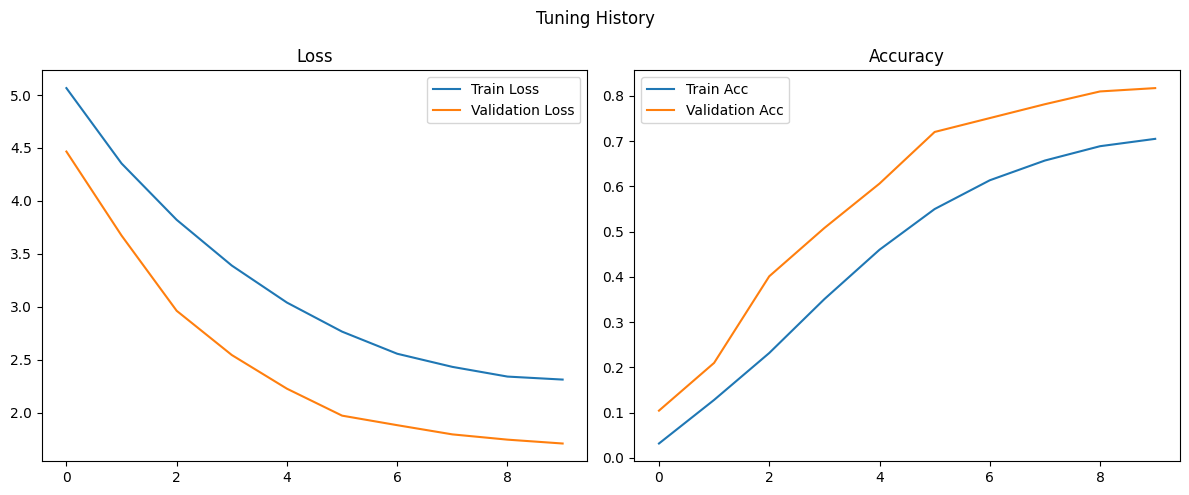

In [11]:
# Load a pretrained ResNet50
model = models.resnet50(pretrained=True)

# Replace the final classification layer
model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))

# Freeze all except layer3, layer4, and fc
for name, param in model.named_parameters():
    param.requires_grad = any(x in name for x in ["layer3", "layer4", "fc"])

# Apply pararellism and move to device
if torch.cuda.device_count()>1: model=nn.DataParallel(model)
model = model.to(device)

# Set configurations
n_epochs = 10
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Proceed with tuning
tuning_metrics1 = train_model(n_epochs, model, train_loader, val_loader, criterion, optimizer)

# Display performance
train_losses, train_accs, val_losses, val_accs = tuning_metrics1
plot_loss_acc(train_losses, train_accs, val_losses, val_accs)

#### **3.2.2 Unfreeze Mid-Level Parameters (Stage 2)**

- Load the best parameter set from the previous run
- Unfreeze `layer2`
- Implement discrimative LR
- Reset the optimizer


Epoch 1/7
  Train Loss: 2.7308 | Acc: 0.4893
  Val   Loss: 2.2845 | Acc: 0.5890
  ⚡ Most Accurate Model Saved

Epoch 2/7
  Train Loss: 2.4398 | Acc: 0.5724
  Val   Loss: 1.9850 | Acc: 0.7006
  ⚡ Most Accurate Model Saved

Epoch 3/7
  Train Loss: 2.2403 | Acc: 0.6406
  Val   Loss: 1.7905 | Acc: 0.7571
  ⚡ Most Accurate Model Saved

Epoch 4/7
  Train Loss: 1.9984 | Acc: 0.7162
  Val   Loss: 1.6691 | Acc: 0.8012
  ⚡ Most Accurate Model Saved

Epoch 5/7
  Train Loss: 1.8406 | Acc: 0.7668
  Val   Loss: 1.5036 | Acc: 0.8552
  ⚡ Most Accurate Model Saved

Epoch 6/7
  Train Loss: 1.7419 | Acc: 0.8052
  Val   Loss: 1.4217 | Acc: 0.8994
  ⚡ Most Accurate Model Saved

Epoch 7/7
  Train Loss: 1.6689 | Acc: 0.8323
  Val   Loss: 1.4030 | Acc: 0.9006
  ⚡ Most Accurate Model Saved
⌛ Avg. Epoch Time: 00:02:36


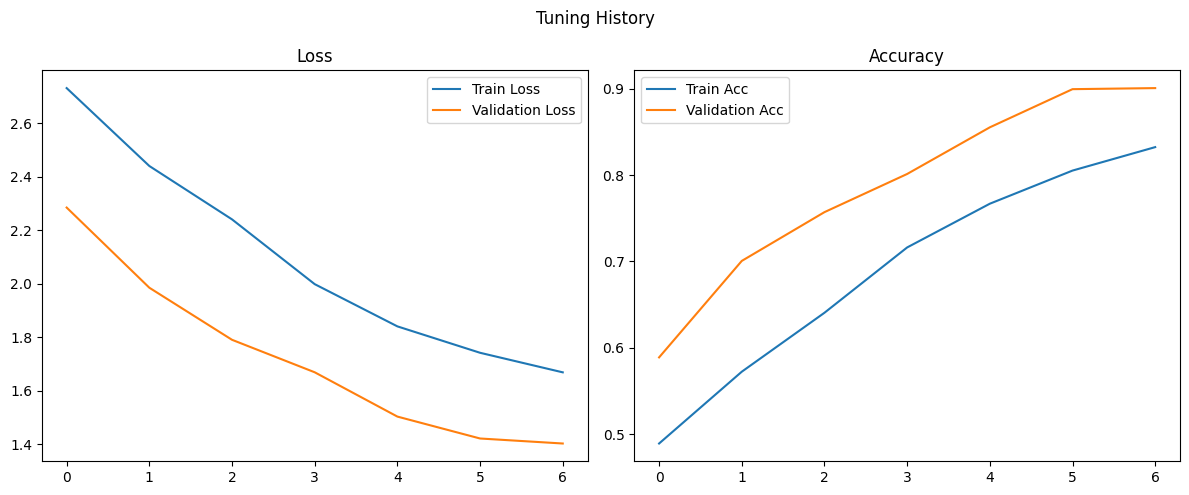

In [12]:
# Load most accurate model
model.load_state_dict(torch.load("best_params.pth"))

# Unfreeze layer2
for param in model.module.layer2.parameters():
    param.requires_grad = True

# Implement discriminative LR per param group
param_groups = [
    {"params": model.module.fc.parameters(), "lr": 3e-4},     
    {"params": model.module.layer4.parameters(), "lr": 2e-4},
    {"params": model.module.layer3.parameters(), "lr": 1e-4},
    {"params": model.module.layer2.parameters(), "lr": 5e-5}]

# Reset optimizer and cosine annealing
optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)

# Lower epoch on 2nd run
n_epochs = 7
tuning_metrics2 = train_model(n_epochs, model, train_loader, val_loader, criterion, optimizer)

# Display performance
train_losses, train_accs, val_losses, val_accs = tuning_metrics2
plot_loss_acc(train_losses, train_accs, val_losses, val_accs)

#### **3.2.3 Unfreeze Early Layers (Stage 3)**

- Load the best parameter set from the previous run
- Unfreeze `layer1` and the stem block
- Reset the optimizer with the new discrimative LRs


Epoch 1/10
  Train Loss: 1.7762 | Acc: 0.7886
  Val   Loss: 1.4716 | Acc: 0.8712
  ⚡ Most Accurate Model Saved

Epoch 2/10
  Train Loss: 1.7271 | Acc: 0.8008
  Val   Loss: 1.4710 | Acc: 0.8663

Epoch 3/10
  Train Loss: 1.6722 | Acc: 0.8138
  Val   Loss: 1.3915 | Acc: 0.8933
  ⚡ Most Accurate Model Saved

Epoch 4/10
  Train Loss: 1.6418 | Acc: 0.8285
  Val   Loss: 1.3743 | Acc: 0.8908

Epoch 5/10
  Train Loss: 1.5985 | Acc: 0.8389
  Val   Loss: 1.3622 | Acc: 0.8969
  ⚡ Most Accurate Model Saved

Epoch 6/10
  Train Loss: 1.5599 | Acc: 0.8525
  Val   Loss: 1.3685 | Acc: 0.9092
  ⚡ Most Accurate Model Saved

Epoch 7/10
  Train Loss: 1.5200 | Acc: 0.8637
  Val   Loss: 1.3177 | Acc: 0.9104
  ⚡ Most Accurate Model Saved

Epoch 8/10
  Train Loss: 1.5054 | Acc: 0.8644
  Val   Loss: 1.2992 | Acc: 0.9043

Epoch 9/10
  Train Loss: 1.4715 | Acc: 0.8777
  Val   Loss: 1.3119 | Acc: 0.9067

Epoch 10/10
  Train Loss: 1.4524 | Acc: 0.8889
  Val   Loss: 1.3000 | Acc: 0.9141
  ⚡ Most Accurate Model Saved

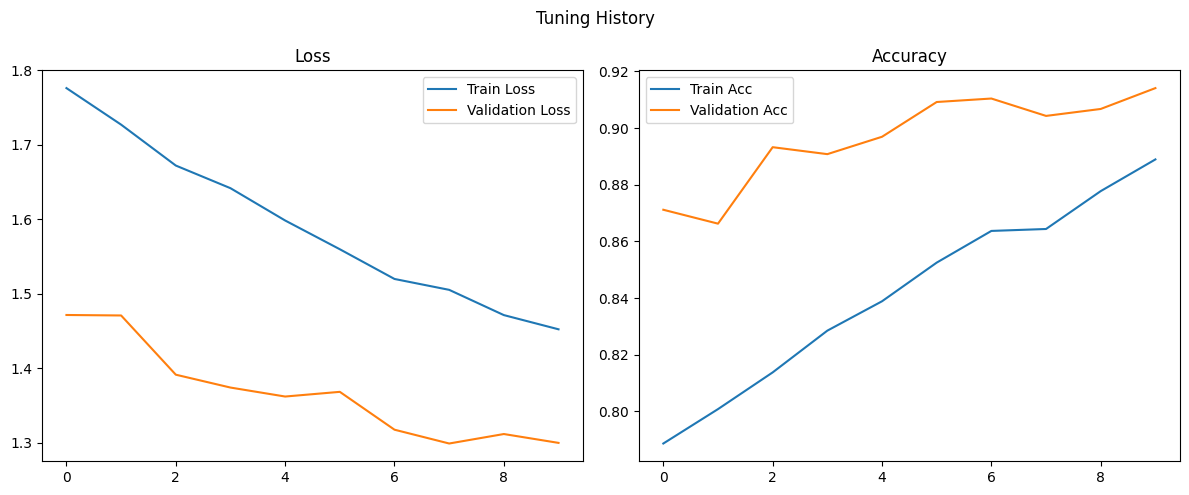

In [13]:
# Load most accurate model
model.load_state_dict(torch.load("best_params.pth"))

# Unfreeze layer1
for param in model.module.layer1.parameters():
    param.requires_grad = True

# Unfreeze conv1 of the stem block
for param in model.module.conv1.parameters():
    param.requires_grad = True

# Unfreeze bn1 of stem
for param in model.module.bn1.parameters():
    param.requires_grad = True

# Update learning rates
param_groups = [
    {"params": model.module.fc.parameters(), "lr": 1e-4},     
    {"params": model.module.layer4.parameters(), "lr": 7e-5},
    {"params": model.module.layer3.parameters(), "lr": 5e-5},
    {"params": model.module.layer2.parameters(), "lr": 2e-5},
    {"params": model.module.layer1.parameters(), "lr": 1e-5},
    {"params": model.module.conv1.parameters(), "lr": 5e-6},
    {"params": model.module.bn1.parameters(), "lr": 5e-6}]

# Reset optimizer
optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

n_epochs = 10
tuning_metrics3 = train_model(n_epochs, model, train_loader, val_loader, criterion, optimizer)

# Display performance
train_losses, train_accs, val_losses, val_accs = tuning_metrics3
plot_loss_acc(train_losses, train_accs, val_losses, val_accs)

### **3.3 Evaluate on the Test Set**

In [14]:
# Load best model
model.load_state_dict(torch.load("best_params.pth"))

# Define test set transforms
test_transforms = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Test dataset
test_data = CarImageDataset(test_paths, test_labels, transform=test_transforms)

# Wrap in DataLoader
test_loader = DataLoader(
    test_data, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2,
    pin_memory=True)

# Evaluate test data 
eval_metrics = evaluate_model(model, test_loader, criterion, add_metrics=True)
loss, acc, prec, rec, f1, inf_time, y_labels, y_preds = eval_metrics
print(f"Loss: {loss:.4f} \nAccuracy: {acc:.4f} \nPrecision: {prec:.4f} \nRecall: {rec:.4f} \nF1: {f1:.4f}, \nInference Time: {inf_time}")

Loss: 1.3082 
Accuracy: 0.9117 
Precision: 0.9134 
Recall: 0.9117 
F1: 0.9110, 
Inference Time: 00:01:37


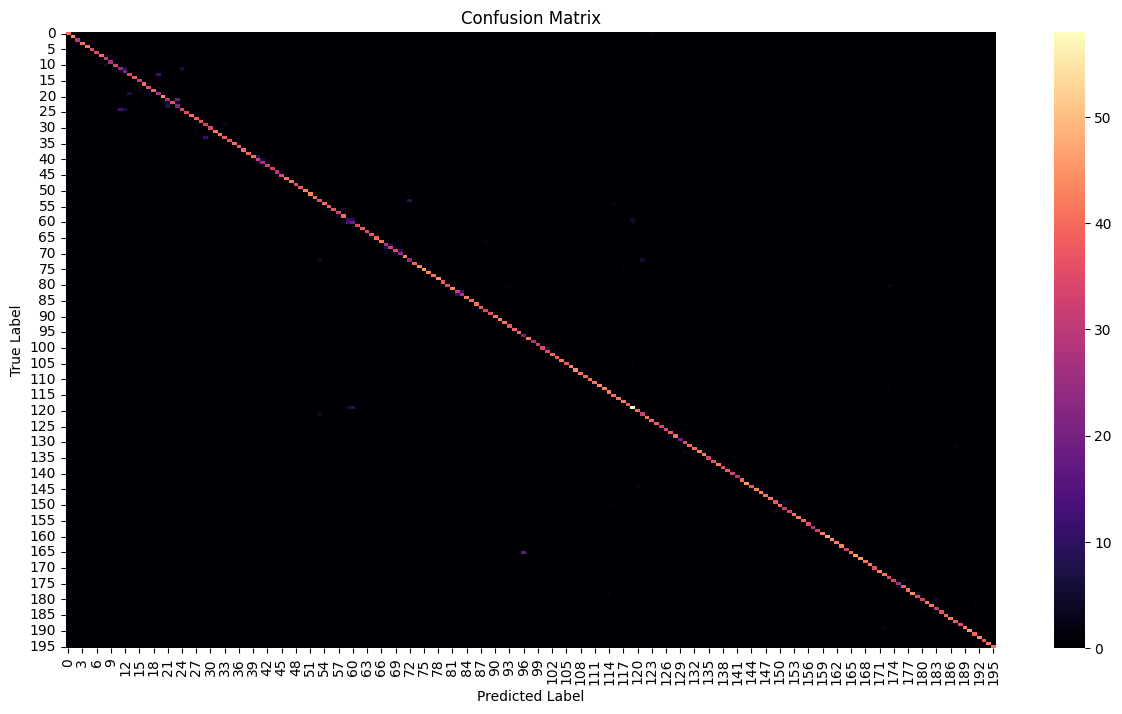

In [15]:
# Confusion matrix utility function
import seaborn as sns 
def generate_conf_matrix(title, model_labels, model_preds):
    y_true = np.array(model_labels)
    y_pred = np.array(model_preds)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 8))
    sns.heatmap(cm, annot=False, cmap="magma")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title}")
    plt.show()

# Generate cm
generate_conf_matrix("Confusion Matrix", y_preds, y_labels)